In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [24]:
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings

warnings.filterwarnings("ignore")
train_dir = '/kaggle/input/mri-dataset-for-alzheimers/alzheimer dataset/train'
test_dir = '/kaggle/input/mri-dataset-for-alzheimers/alzheimer dataset/test'
img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    # shear_range=0.1,
    zoom_range=0.10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    # horizontal_flip=True,
    rotation_range=10,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=False,
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 3719 images belonging to 4 classes.
Found 928 images belonging to 4 classes.
Found 1813 images belonging to 4 classes.


In [32]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import numpy as np

classes = train_generator.classes
weights = compute_class_weight(class_weight='balanced', classes=np.unique(classes), y=classes)
class_weights = dict(zip(np.unique(classes), weights))

CNN1 = Sequential()

CNN1.add(Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)))
CNN1.add(BatchNormalization())
CNN1.add(MaxPooling2D(2,2))

CNN1.add(Conv2D(64, (3,3), activation='relu'))
CNN1.add(BatchNormalization())
CNN1.add(MaxPooling2D(2,2))

CNN1.add(Conv2D(128, (3,3), activation='relu'))
CNN1.add(BatchNormalization())
CNN1.add(MaxPooling2D(2,2))

# CNN1.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# CNN1.add(BatchNormalization())
# CNN1.add(MaxPooling2D(2,2))

# CNN1.add(Conv2D(256, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# CNN1.add(BatchNormalization())
# CNN1.add(MaxPooling2D(2,2))

CNN1.add(GlobalAveragePooling2D())

CNN1.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
CNN1.add(BatchNormalization())
CNN1.add(Dropout(0.5))

# CNN1.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# CNN1.add(BatchNormalization())
# CNN1.add(Dropout(0.2))

CNN1.add(Dense(4, activation='softmax'))

optimizer = Adam(learning_rate=3e-4)
CNN1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
CNN1.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,108 (434.02 KB)

 Trainable params: 110,404 (431.27 KB)

 Non-trainable params: 704 (2.75 KB)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
      EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
      ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
      ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
  ]

In [35]:
history = CNN1.fit(train_generator, validation_data=val_generator, class_weight=class_weights, callbacks=[callbacks], epochs=40)

Epoch 1/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4205 - loss: 1.3299
Epoch 1: val_loss did not improve from 1.12235
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.4206 - loss: 1.3298 - val_accuracy: 0.5938 - val_loss: 1.3598 - learning_rate: 1.1719e-06
Epoch 2/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4334 - loss: 1.3212
Epoch 2: val_loss did not improve from 1.12235
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.4334 - loss: 1.3213 - val_accuracy: 0.4246 - val_loss: 1.7905 - learning_rate: 1.1719e-06
Epoch 3/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4327 - loss: 1.2747
Epoch 3: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 3: val_loss did not improve from 1.12235
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.4327 - loss: 1.2751 - val_accuracy: 0.2716 - val_loss: 2.0915 - learning_rate: 1.1719e-06
Epoch 4/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4502 - loss: 1.3409
Epoch 4: val

In [36]:
test_loss, test_acc = CNN1.evaluate(test_generator, verbose=1)
print("Test accuracy:", test_acc)

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.2666 - loss: 2.5853
Test accuracy: 0.24379481375217438


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step


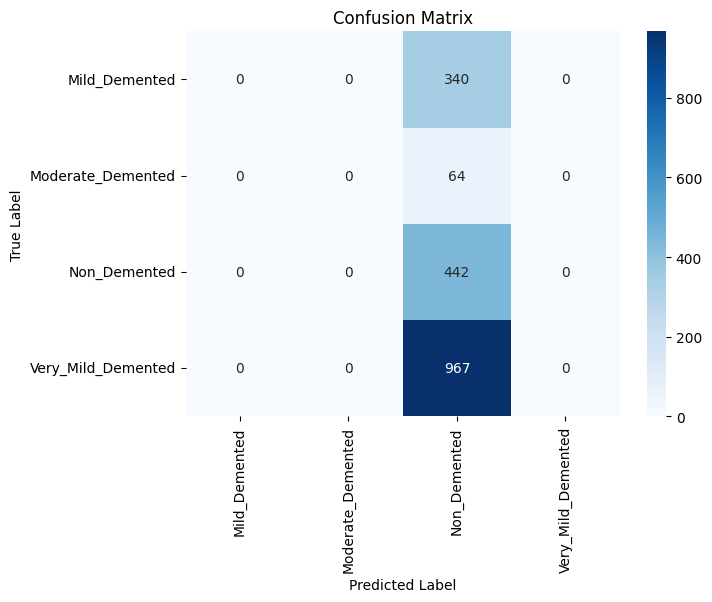

                    precision    recall  f1-score   support

     Mild_Demented     0.0000    0.0000    0.0000       340
 Moderate_Demented     0.0000    0.0000    0.0000        64
      Non_Demented     0.2438    1.0000    0.3920       442
Very_Mild_Demented     0.0000    0.0000    0.0000       967

          accuracy                         0.2438      1813
         macro avg     0.0609    0.2500    0.0980      1813
      weighted avg     0.0594    0.2438    0.0956      1813



In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

  # Predict on test set
test_generator.reset()
y_prob = CNN1.predict(test_generator, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes

# Class names in correct index order
class_names = [k for k, v in sorted(test_generator.class_indices.items(), key=lambda x: x[1])]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(
  cm,
  annot=True,
  fmt='d',
  cmap='Blues',
  xticklabels=class_names,
  yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Optional: detailed report (precision/recall/F1)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))